\newpage

0. Import dataset and necessary libraries.

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import scale
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.metrics.cluster import rand_score

chronic_kidney_disease = fetch_ucirepo(id=336)

x = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

ckd = x.join(y)

x.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no


1. This dataset will be the subject of a binary classification problem. In the dataset, each datapoint represents a patient, and the variables represent various medical statistics for the patient. We will train models to use the dataset variables (features) to classify each patient into one of two groups (classes). In this case, the groups are `ckd`, which refers to the presence of chronic kidney disease, or `notckd`, which refers to the absence of chronic kidney disease. Binary classification is a form of supervised learning.

2. The dataset has many non-numerical variables. Most of these are binary object variables, for example `normal` or `abnormal`. We can either convert these to binary numerical variables (`0` or `1`) or we can drop these variables. We will drop them for two reasons. First, there are already many numerical variables, so we will likely find a suitable subset from these columns. Second, there is a significant number of NaN values, and after the removing these the dataset becomes quite small if we keep all variables. We will see later that the models perform quite well without the binary variables.

In [3]:
#cat_col = x.select_dtypes(include=['object']).columns

#for col in cat_col:
#    x[col] = x[col].astype('category').cat.codes

x = x.drop(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], axis=1)

y

,class
0,ckd
1,ckd
2,ckd
3,ckd
4,ckd
...,...
395,notckd
396,notckd
397,notckd
398,notckd


Now all variables are 64-bit floats. To optimize the classification process, we will standardize the dataset.

In [4]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

3. We will explore the full dataset, including the variables that were previously removed.

In [5]:
ckd.shape

(400, 25)

The dataset has 25 columns (24 features and 1 label), and 400 observations.

In [6]:
ckd.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

The 24 variables are either 64-bit floats and strings. The numerical variables are `age` (age), `bp` (blood pressure), `sg` (specific gravity), `al` (albumin), `su` (sugar), `bgr` (blood glucose random), `bu` (blood urea), `sc` (serum creatinine), `sod` (sodium), `pot` (potassium), `hemo` (hemoglobin), `pcv` (packed cell volume), `wbcc` (white blood cell count), and `rbcc` (red blood cell count). The object variables are `rbc` (red blood cells), `pc` (pus cell), `pcc` (pus cell clumps), `ba` (bacteria), `htn` (hypertension), `dm` (diabetes mellitus), `cad` (coronary artery disease), `appet` (appetite), `pe` (pedal anemia), `ane` (edema). The object variables are all binary, with only two unique values (for example, `present` and `notpresent`). The label is `class`, which indicates the presence or absence of chronic kidney disease as mentioned previously.

In [7]:
ckd.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


All of the varialbes have missing values. The variable means range from 0.45 to 8406. The standard deviations range from 0 to 2944. Minimum values range from 0 to 2200, and maximums range from 1 to 26400. There is significant variance across the variables, so we will have to standardize the dataset before continuning with the binary classification.

In [ ]:
ckd.describe(include='object')

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
count,248,335,396,396,398,398,398,399,399,399,400
unique,2,2,2,2,2,3,2,2,2,2,3
top,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
freq,201,259,354,374,251,260,364,317,323,339,248


We notice that the `dm` and `class` columns have 3 unique values when they should have 2. This is due to errors in the data. This is not important for the `dm` variable because we removed it, but we must remove the inconsistent `class` values from our response variable `y`. First we identify the inconsistent value and then drop all rows containing this value. Finally, we categorize the response variable.

In [9]:
print(y['class'].unique())

y = y.drop(y[y['class'] == 'ckd\t'].index)

print(y['class'].unique())

y['class'] = y['class'].astype('category').cat.codes

print(y['class'].unique())

['ckd' 'ckd\t' 'notckd']
['ckd' 'notckd']
[0 1]


4. We can study variable association using a correlation heatmap.

Text(0.5, 1.0, 'Chronic Kidney Disease Dataset Correlation Heatmap')

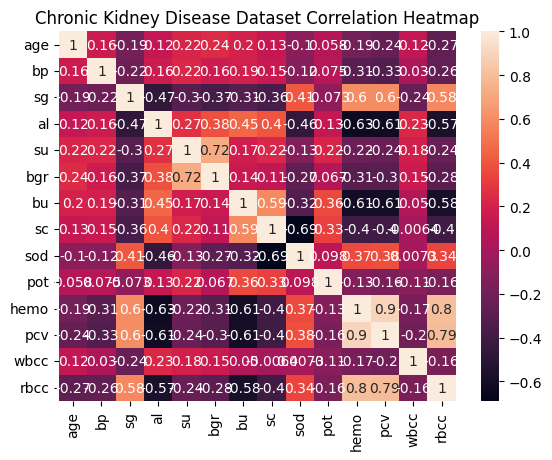

In [10]:
sb.heatmap(x.corr(), annot=True)
plt.title('Chronic Kidney Disease Dataset Correlation Heatmap')

The following groups of variables have high positive correlation:

- `hemo` (hemoglobin), `rbcc` (red blood cell count), `pcv` (packed cell volume) and `sg` (specific gravity)
- `bgr` (blood glucose random) and `su` (sugar)
- `sc` (serum creatinine) and `bu` (blood urea)

Conversely, `al` (albumin) and `bu` (blood urea) have strong negative correlation with `hemo` (hemoglobin), `rbcc` (red blood cell count), `pcv` (packed cell volume) and `sg` (specific gravity). Also, `sod` (sodium) and `sc` (serum creatinine) are strongly negatively correlated. The remaining variables have correlation around 0.

The presence of strongly correlated variables means that some features will be redundant in the classification problem. This will become apparent when we perform feature selection. On the other hand, the signficant number of independent variables means that the models should have sufficient information to perform well. We expect that features selection will identify a mostly independent variables, and maybe one of the highly correlated variables.

5. First we count the number of missing values in the data.

In [11]:
print(x.isnull().sum().sum())

778


  There are 778 empty cells. We can remove all rows with missing values, but first we must combine `x` and `y` into one dataframe so that rows removed from `x` are also removed from `y`. Then we can split them back into separate dataframes.

In [12]:
ckd = x.join(y)
ckd = ckd.dropna()

print(ckd.shape)

x = ckd.drop(['class'], axis=1)
y = ckd['class']

(203, 15)


  After dropping rows with empty cells, there are only 203 rows left in the dataset (versus 400 originally).

6. We can visualize outliers in the data using boxplot.

<Axes: >

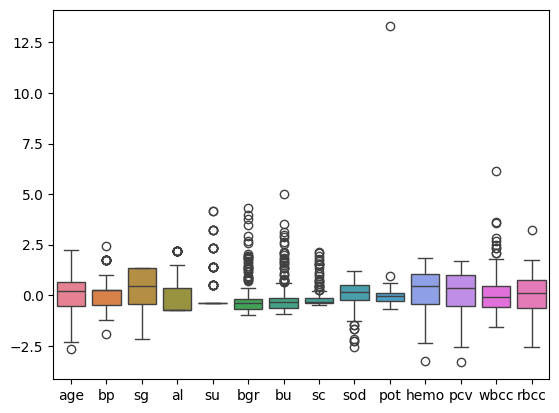

In [13]:
sb.boxplot(x)

It is clear that many variables have a signficiant number of outliers. These datapoints could skew the results of the classification models. Before continuing with the classification problem, we will set all outliers below the 10th percentile equal to the 10% value, and all outliers above the 90th percentile equal to the 90% value for each variable distribution.

In [14]:
for col in x.columns:
  x[col] = np.where(np.abs(x[col]) < np.quantile(x[col], 0.1), np.quantile(x[col], 0.1), x[col])
  x[col] = np.where(np.abs(x[col]) > np.quantile(x[col], 0.9), np.quantile(x[col], 0.9), x[col])

We visualize the distributions again:

<Axes: >

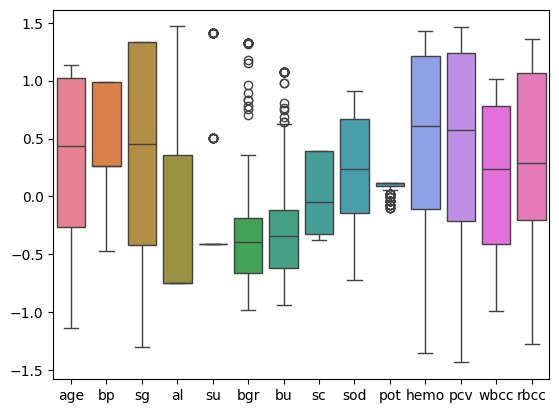

In [15]:
sb.boxplot(x)

There are still some outliers remaining, but the majority have been removed and the dataset is now likely to yield better results. There are few outliers and they are closer to the median, so they are less likely to skew the results.

7. Subgroup analysis

PC1     2.599365
PC2     0.872335
PC3     0.488544
PC4     0.435013
PC4     0.386512
PC6     0.337605
PC7     0.314452
PC8     0.295543
PC9     0.180225
PC10    0.151946
PC11    0.138812
PC12    0.090178
PC13    0.070589
PC14    0.003193
dtype: float64
[0.40842832 0.13706668 0.07676299 0.06835201 0.0607311  0.05304663
 0.04940863 0.04643754 0.028318   0.02387466 0.021811   0.01416932
 0.01109144 0.00050167]


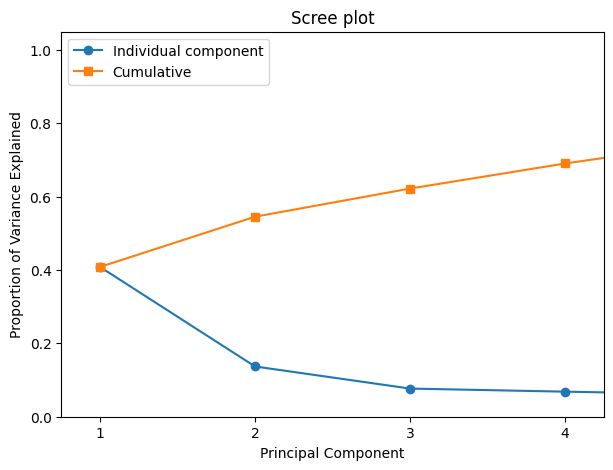

In [16]:
pca_x = PCA()

pca_loadings = pd.DataFrame(pca_x.fit(x).components_.T, index=x.columns, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC4', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14'])

pc_scores = pd.DataFrame(pca_x.fit_transform(x), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC4', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14'], index=x.index)

plt.figure(figsize=(7,5))

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], pca_x.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14], np.cumsum(pca_x.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Scree plot')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2);

print(pc_scores.var())
print(pca_x.explained_variance_ratio_)

           PC1       PC2       PC3       PC4       PC4       PC6       PC7  \
age   0.134882 -0.020762 -0.782777 -0.314090 -0.200270 -0.303481 -0.346564   
bp    0.051786  0.088892  0.087792  0.178471  0.042204  0.483678 -0.574210   
sg   -0.464333 -0.392711  0.185598 -0.282886 -0.185133 -0.248910  0.229155   
al    0.447238  0.231702  0.244852 -0.089383 -0.576921 -0.129273  0.172225   
su    0.218719  0.229206  0.104708 -0.342487  0.348087 -0.147752  0.072382   
bgr   0.283855  0.184748  0.150634 -0.340855  0.479760 -0.135739  0.031294   
bu    0.220859  0.173630  0.163318  0.078090 -0.393515 -0.040490 -0.033298   
sc    0.018253  0.062753  0.051826 -0.009745 -0.179648 -0.000300 -0.045704   
sod  -0.098339 -0.110796 -0.133801  0.133591 -0.048203  0.084423  0.100618   
pot   0.000816  0.004847  0.001257  0.009390 -0.011017 -0.003753  0.006410   
hemo -0.359177  0.433206 -0.029853 -0.346498 -0.074857  0.190680  0.087275   
pcv  -0.380085  0.491511 -0.087610 -0.196060 -0.148059  0.251181

Text(0.5, 1.0, 'Subgroup Analysis')

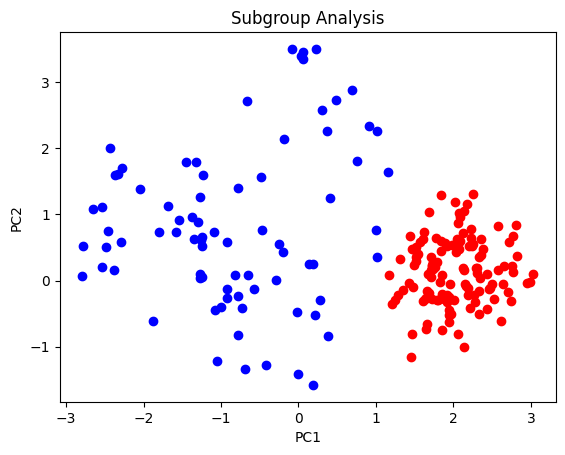

In [17]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(x)
pc_score_svd = svd.transform(x)
pc_score_svd = pd.DataFrame(pc_score_svd, columns=['PC1', 'PC2'], index=x.index)

print(pca_loadings)

plt.scatter(pc_score_svd[y==0].PC1, pc_score_svd[y==0].PC2, color="blue")
plt.scatter(pc_score_svd[y==1].PC1, pc_score_svd[y==1].PC2, color="red")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Subgroup Analysis")

Based on the principal component analysis, it appears that there are subgroups within the data.

8. We can now separate the data into training and test sets (70% and 30% of the original dataset, respectively)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

9. For this exercise we will use Logistic Regression and K-Nearest Neighbors, because we have experience with these models and they are well suited to binary classification problems. They are also simple to implement and train quickly. Logistic regression has the added benefit of accepting categorical variables, though we will not use them.

10. We will evaluate our models using the accuracy and area under the receiver operating characteristics curve metrics (ROC-AUC). Both metrics score the model from 0 to 1.

  Accuracy represents the number of correct classifications divided by the total number of predictions. We use accuracy because it is easy to understand and it provides a useful measure of the model performance.

  ROC-AUC represents the performance of the model for different decision thresholds. The ROC shows the relationship between ture positive rate and false positive rate for different thresholds, and the aera under this curve gives a measure of model performance. We use ROC-AUC because it provides a more robust indicator of model performance.

11. We will perform feature selection using both exhaustive and sequential methods. Additionally, we will find the optimal K-value for the KNN model. The optimization codes are incorporated into the next section.

12. First, we train both models without any optimizations. For the KNN model, we determine the optimal K-value.

In [19]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print(metrics.accuracy_score(y_test,y_pred_lr))
print(metrics.roc_auc_score(y_test,y_pred_lr))

1.0
1.0


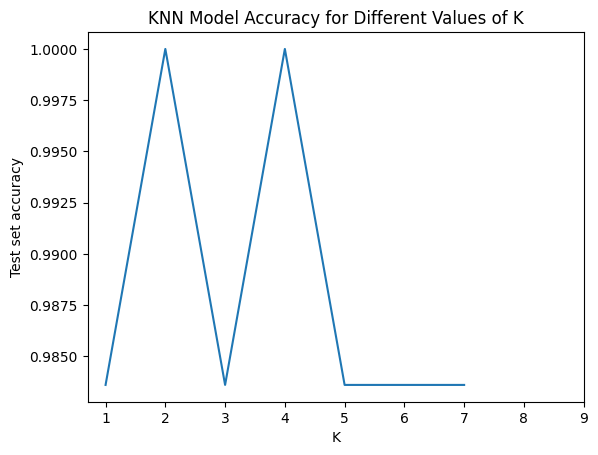

1.0
1.0


In [20]:
k_range = range(1, 8)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('K')
plt.ylabel('Test set accuracy')
plt.xticks(range(1,10))
plt.title('KNN Model Accuracy for Different Values of K')
plt.show()

knn2 = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
knn2.fit(x_train, y_train)
y_pred_knn2 = knn2.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_knn2))
print(metrics.roc_auc_score(y_test,y_pred_knn2))

  The two models have the same accuracy, they both perform perfectly. We can show an attempt to improve the models' performance using feature selection, using the exhaustive feature selection method. The scores will not be any higher, but feature extraction will allow the models to run faster, which is an improvment. These codes are adapted from lecture.

  For the logistic regression model:

In [21]:
efs = EFS(lr, min_features=1, max_features=5, scoring='r2', cv=10)

y_train_efs = y_train
y_train_efs = y_train.astype('category').cat.codes

efs.fit(x_train, y_train_efs)

lr_efs_columns = x_train.columns[list(efs.best_idx_)]
print('Best subset:', lr_efs_columns)

x_train_lr_efs = x_train[lr_efs_columns]
x_test_lr_efs = x_test[lr_efs_columns]

lr_efs = LogisticRegression()
lr_efs.fit(x_train_lr_efs, y_train)
y_pred_lr_efs = lr_efs.predict(x_test_lr_efs)

print(metrics.accuracy_score(y_test, y_pred_lr_efs))
print(metrics.roc_auc_score(y_test,y_pred_lr_efs))

Features: 3472/3472

Best subset: Index(['sg', 'al', 'hemo', 'pcv'], dtype='object')
1.0
1.0


  For the KNN model:

In [22]:
efs = EFS(knn2, min_features=1, max_features=5, scoring='r2', cv=10)

y_train_efs = y_train
y_train_efs = y_train.astype('category').cat.codes

efs.fit(x_train, y_train_efs)

print('Best subset:', efs.best_idx_)
knn2_efs_columns = x_train.columns[list(efs.best_idx_)]

x_train_knn2_efs = x_train[knn2_efs_columns]
x_test_knn2_efs = x_test[knn2_efs_columns]

knn2_efs = LogisticRegression()
knn2_efs.fit(x_train_knn2_efs, y_train)
y_pred_knn2_efs = knn2_efs.predict(x_test_knn2_efs)

print(metrics.accuracy_score(y_test, y_pred_knn2_efs))
print(metrics.roc_auc_score(y_test,y_pred_knn2_efs))

Features: 3472/3472

Best subset: (1, 2, 3, 10, 11)
1.0
1.0


  Feature selection identifies similar subsets for both models. The model scores are unchanged after feature selection.

13. First we retrain the logistic regression model with the whole dataset. Then we construct a table that summarizes the coefficients for each feature.

In [23]:
lr2 = LogisticRegression()
lr2.fit(x, y)
y_pred_lr2 = lr2.predict(x_test)

print(metrics.accuracy_score(y_test,y_pred_lr))
print(metrics.roc_auc_score(y_test,y_pred_lr))

coefs = pd.DataFrame({'Variable': x.columns})

coefs['Weight'] = lr2.coef_.transpose()

coefs

1.0
1.0


,Variable,Weight
0,age,-0.226037
1,bp,0.113847
2,sg,2.035091
3,al,-1.762627
4,su,-0.917093
5,bgr,-0.719805
6,bu,-1.129239
7,sc,0.079041
8,sod,0.455508
9,pot,-0.029589


The most highly positive weighted variables are `sg` (specific gravity), `hemo` (hemoglobin) and `pcv` (packed cell volume). We can interpret this to mean that these variables are strong indicators of the presence of chronic kidney disease.

The most highly hegative weighted variables are `al` (albumin), `su` (sugar), and `bu` (blood urea). We can interpret this to mean that these variables are strong indicators of the absence of chronic kidney disease.

There are also variables with coefficient close to 0, such as `sc` (serum creatinine) and `pot` (potassium). These variables do not have a noticeable impact on the final prediction of the model.

It is interesting to note that the feature selection carried out in question 11 did not select any of the variables from the third group, because they do not have an impact on the decision so they are not worth extracting.

15. Individual assignment completed by Thomas French

16. https://github.com/tfren99/STATS_3DA3_A6_ThomasFrench